Jaccard analysis to compare oviIN input subconnectome clustering to full Hemibrain clustering. 

In [1]:
import pandas as pd
import numpy as np
import itertools

In [2]:
# load package
import matplotlib
import matplotlib.patheffects as path_effects
import matplotlib as mpl


In [3]:
matplotlib.use('TkAgg')  # or 'Qt5Agg', 'MacOSX', etc.
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator,FormatStrFormatter,MaxNLocator
%matplotlib inline

We import the output of modularity run for chi = 0.0 

In [4]:
chi_run = {}

with open('modularity_runs/0.0/0-0_98765.txt', 'r') as f:
    for line in f:
        node, cluster = line.split()
        node = int(node)
        cluster = int(cluster)
        chi_run[node] = cluster

In [5]:
len(chi_run)

1832

We also read in the clustering for the entire hemibrain

In [6]:
df = pd.read_csv('data/preprocessed-v1.2/preprocessed_nodes.csv')

In [7]:
df

,id,0.75,0.05,0.1,0.25,0.5,1.0,0.0,instance,celltype,...,size,status,cropped,statusLabel,cellBodyFiber,somaRadius,somaLocation,inputRois,outputRois,roiInfo
0,200326126,1,1,1,1,1,1,1,CL141_L,CL141,...,827930581,Traced,False,Roughly traced,PDL20,251.0,"[3844, 14565, 15568]","['AVLP(R)', 'IB', 'ICL(R)', 'INP', 'LH(R)', 'M...","['AVLP(R)', 'ICL(R)', 'INP', 'LH(R)', 'MB(+ACA...","{'SNP(R)': {'pre': 17, 'post': 19, 'downstream..."
1,202916528,2,2,2,2,2,2,2,FS4C(FQ12)_C4_R,FS4C,...,235674230,Traced,False,Roughly traced,PDM03,301.0,"[20091, 12266, 12208]","['CX', 'FB', 'FB-column3', 'FBl1', 'FBl2', 'FB...","['CX', 'FB', 'FBl7', 'SMP(L)', 'SNP(L)']","{'SNP(L)': {'pre': 93, 'post': 35, 'downstream..."
2,203253072,3,2,3,3,3,3,2,FS4A(AB)(FQ12)_C3_R,FS4A,...,154283963,Traced,False,Roughly traced,PDM03,236.0,"[17809, 10233, 14208]","['AB(R)', 'CRE(-RUB)(L)', 'CRE(L)', 'CX', 'FB'...","['AB(R)', 'CX', 'FB', 'FB-column3', 'FBl1', 'F...","{'SNP(L)': {'pre': 52, 'post': 30, 'downstream..."
3,203253253,4,3,3,4,4,4,2,SMP505(PDM22)_L,SMP505,...,1763416504,Traced,False,Roughly traced,NaN,351.0,"[32168, 13757, 13336]","['ATL(L)', 'CRE(-RUB)(L)', 'CRE(L)', 'ICL(L)',...","['SIP(L)', 'SIP(R)', 'SLP(R)', 'SMP(L)', 'SMP(...","{'SNP(L)': {'pre': 150, 'post': 2282, 'downstr..."
4,203257652,5,2,3,2,2,2,2,FS4C(FQ12)_C6_R,FS4C,...,209983364,Traced,False,Roughly traced,PDM02,301.0,"[22758, 16749, 10240]","['CX', 'FB', 'FBl1', 'FBl2', 'FBl3', 'FBl4', '...","['SIP(L)', 'SMP(L)', 'SNP(L)']","{'SNP(L)': {'pre': 65, 'post': 36, 'downstream..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21734,7112579856,2322,1,1,157,1064,3243,1,LC20,LC20,...,462394896,Traced,False,Roughly traced,NaN,301.5,"[7883, 23524, 33072]","['LO(R)', 'OL(R)', 'PLP(R)', 'VLNP(R)']","['LO(R)', 'OL(R)', 'PLP(R)', 'VLNP(R)']","{'OL(R)': {'pre': 268, 'post': 594, 'downstrea..."
21735,7112615127,2670,9,19,46,226,3110,6,AVLP335_R,AVLP335,...,453081149,Traced,False,Roughly traced,AVL13,NaN,NaN,"['AVLP(R)', 'PVLP(R)', 'VLNP(R)']","['AVLP(R)', 'PVLP(R)', 'VLNP(R)']","{'VLNP(R)': {'pre': 362, 'post': 577, 'downstr..."
21736,7112617294,2386,9,19,46,226,3362,6,AVLP331_R,AVLP331,...,438751734,Traced,False,Roughly traced,AVL13,NaN,NaN,"['AVLP(R)', 'PVLP(R)', 'VLNP(R)']","['AVLP(R)', 'PVLP(R)', 'VLNP(R)']","{'VLNP(R)': {'pre': 285, 'post': 661, 'downstr..."
21737,7112622044,879,3,8,14,120,2836,3,LAL137(PVL05)_L,LAL137,...,1529252938,Traced,False,Roughly traced,NaN,NaN,NaN,"['CRE(-ROB,-RUB)(R)', 'CRE(-RUB)(L)', 'CRE(L)'...","['CRE(-ROB,-RUB)(R)', 'CRE(-RUB)(L)', 'CRE(L)'...","{'SNP(R)': {'pre': 304, 'post': 130, 'downstre..."


## Preprocessing the nodes to create cluster dicts

We create dictionaries of different clusterings for ease of processing. We take only the nodes that are present in the subconnectome from the full connectome when working with the Hemibrain clustering data. This means that there will be the same number of nodes across the 2 datasets that we compare.

In [8]:
hemibrain_clusters = {}
resolutions = ['0.0', '0.05', '0.1', '0.25', '0.5', '0.75', '1.0']
for res in resolutions:
    hemibrain_clusters[res] = {}
for _, row in df.iterrows():
    node = row['id']
    for res in resolutions:
        hemibrain_clusters[res][node] = row[res]
    

In [9]:
for n in chi_run:
    for res in resolutions:
        assert  n in hemibrain_clusters[res]

In [10]:
hemibrain_clusters_filtered = {}
for res in resolutions:
    hemibrain_clusters_filtered[res] = {}
    for n in chi_run:
        hemibrain_clusters_filtered[res][n] = hemibrain_clusters[res][n]

In [11]:
del hemibrain_clusters

## Cluster Similarity Analysis
Pairwise similarity. A random baseline was generated by shuffling the cluster labels of the subconnectome coarse clustering.

In [12]:
import itertools

def cluster_similarity(cluster_1, cluster_2, mode='both', node_filter=None):
    """
    Calculate the similarity between two clusterings using either the Jaccard index, Rand index, or both.

    Parameters:
    cluster_1 (dict): A dictionary representing the first clustering where keys are nodes and values are cluster labels.
    cluster_2 (dict): A dictionary representing the second clustering where keys are nodes and values are cluster labels.
    mode (str): The similarity measure to use ('jaccard', 'rand', or 'both'). Defaults to 'both'.
    node_filter (set, optional): A set of nodes to include in the comparison. If None, all nodes are included.

    Returns:
    float or tuple: The Jaccard index, Rand index, or both depending on the selected mode.
    
    Raises:
    AssertionError: If the mode is not one of 'jaccard', 'rand', or 'both', or if the clusterings do not have the same nodes.
    """
    # Ensure the mode is one of the valid options
    assert mode in ['jaccard', 'rand', 'both'], "Not a valid mode, please choose 'jaccard', 'rand' or 'both'"
    # Ensure both clusterings have the same set of nodes
    assert set(cluster_1.keys()) == set(cluster_2.keys())
    nodes = set(cluster_1.keys())
    
    # Apply node filter if provided
    if node_filter is not None:
        filter_set = set(node_filter)
        nodes = nodes.intersection(filter_set)
    
    # Initialize counters for pair counts
    f_0_0 = 0  # pair in different clusters in both clusterings
    f_0_1 = 0  # pair in different clusters in cluster_1 and same in cluster_2
    f_1_0 = 0  # pair in same cluster in cluster_1 and different in cluster_2
    f_1_1 = 0  # pair in same clusters in both clusterings

    # Count the number of pairs in each category
    for n1, n2 in itertools.combinations(nodes, 2):
        if cluster_1[n1] == cluster_1[n2] and cluster_2[n1] == cluster_2[n2]:
            f_1_1 += 1
        elif cluster_1[n1] == cluster_1[n2] and cluster_2[n1] != cluster_2[n2]:
            f_1_0 += 1
        elif cluster_1[n1] != cluster_1[n2] and cluster_2[n1] == cluster_2[n2]:
            f_0_1 += 1
        else:
            f_0_0 += 1
    #print(f_0_0 + f_1_0 + f_1_1 + f_0_1)
    # Calculate and return the similarity measure(s)
    if mode == 'jaccard':
        return f_1_1 / (f_1_1 + f_0_1 + f_1_0)
    if mode == 'rand':
        return (f_1_1 + f_0_0) / (f_1_1 + f_1_0 + f_0_1 + f_0_0)
    
    return f_1_1 / (f_1_1 + f_0_1 + f_1_0), (f_1_1 + f_0_0) / (f_1_1 + f_1_0 + f_0_1 + f_0_0)


In [13]:
jaccard_index, rand_score = cluster_similarity(hemibrain_clusters_filtered['0.0'], chi_run)
jaccard_index

0.17465190122957694

In [14]:
import random

In [15]:
# Shuffle the values in the dictionary for random baseline
values = list(chi_run.values())
random.shuffle(values)
chi_run_random = dict(zip(chi_run.keys(), values))

jaccard_index, rand_score = cluster_similarity(chi_run, chi_run_random)
jaccard_index

0.08064470808954327

In [16]:
jac_indices = {}
rand_scores = {}
jac_indices_random = {}
rand_scores_random = {}

for res in resolutions:
    jaccard_index, rand_score = cluster_similarity(hemibrain_clusters_filtered[res], chi_run)
    print(jaccard_index, rand_score)
    jac_indices[res] = jaccard_index
    rand_scores[res] = rand_score

    # Shuffle the values in the dictionary for random baseline
    values = list(chi_run.values())
    random.shuffle(values)
    chi_run_random = dict(zip(chi_run.keys(), values))
    
    jaccard_index_random, rand_score_random = cluster_similarity(hemibrain_clusters_filtered[res], chi_run_random)
    jac_indices_random[res] = jaccard_index_random
    rand_scores_random[res] = rand_score_random


0.17465190122957694 0.5569176172611907
0.16763697666566627 0.5766749980324303
0.16430728416326748 0.5898070350752088
0.1775958560570173 0.7940145337813828
0.10671776113336817 0.8624042747538153
0.021753416146594606 0.8535502111858125
0.009658133984658732 0.8520471071955812


In [19]:
import matplotlib.pyplot as plt
#plt.style.use('default')

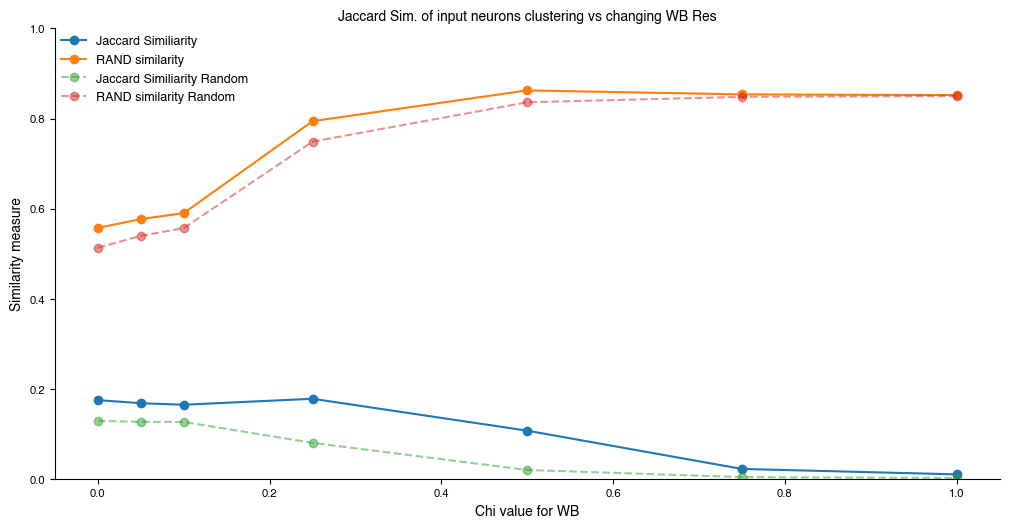

In [17]:
plt.figure(figsize=(10, 5))
plt.plot([float(res) for res in resolutions], [jac_indices[res] for res in resolutions], marker='o', label = 'Jaccard Similiarity')
plt.plot([float(res) for res in resolutions], [rand_scores[res] for res in resolutions], marker='o', label = 'RAND similarity')
plt.plot([float(res) for res in resolutions], [jac_indices_random[res] for res in resolutions], marker='o', label = 'Jaccard Similiarity Random', linestyle = '--', alpha = 0.5)
plt.plot([float(res) for res in resolutions], [rand_scores_random[res] for res in resolutions], marker='o', label = 'RAND similarity Random', linestyle = '--', alpha = 0.5)
plt.legend(loc='upper left')
plt.tight_layout()
plt.ylim(0, 1)
plt.xlabel('Chi value for WB')
plt.ylabel('Similarity measure')
plt.title('Jaccard Sim. of input neurons clustering vs changing WB Res')
plt.show()

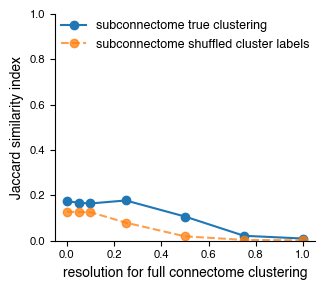

In [19]:
fig = plt.figure(figsize=(3.35, 3))
plt.plot([float(res) for res in resolutions], [jac_indices[res] for res in resolutions], marker='o', label = 'subconnectome true clustering')

plt.plot([float(res) for res in resolutions], [jac_indices_random[res] for res in resolutions], marker='o', label = 'subconnectome shuffled cluster labels', linestyle = '--', alpha = 0.75)

plt.legend(loc='upper left')
plt.tight_layout()
plt.ylim(0, 1)
plt.xlabel('resolution for full connectome clustering')
plt.ylabel('Jaccard similarity index')
#plt.title('Clustering comparison across resolutions')

plt.tight_layout()
plt.show()

In [20]:
# save as pdf
fig.savefig('figures/jaccard_clustering_comparison.pdf', bbox_inches='tight')

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


In case we want to run multiple trials of random shuffles but that doesn't seem necessary.

In [18]:
import math

jac_indices = {}
rand_scores = {}
jac_indices_random_mean = {}
rand_scores_random = {}
jac_rand = {}
jac_indices_random_std = {}

n_trials = 100

for res in resolutions:
    jaccard_index, rand_score = cluster_similarity(hemibrain_clusters_filtered[res], chi_run)
    print(jaccard_index, rand_score)
    jac_indices[res] = jaccard_index
    rand_scores[res] = rand_score

    for nr in range(n_trials):
        # Shuffle the values in the dictionary for random baseline
        values = list(chi_run.values())
        random.shuffle(values)
        chi_run_random = dict(zip(chi_run.keys(), values))

        jaccard_index_random, rand_score_random = cluster_similarity(hemibrain_clusters_filtered[res], chi_run_random)
        jac_rand[nr] = jaccard_index_random

    # Calculate the mean of the random baseline
    jac_indices_random_mean[res] = sum(jac_rand.values())/n_trials

    # Calculate the variance
    variance = sum((x - jac_indices_random_mean[res]) ** 2 for x in jac_rand.values()) / n_trials

    # Calculate the standard deviation
    jac_indices_random_std[res] = math.sqrt(variance)

0.17465190122957694 0.5569176172611907
0.16763697666566627 0.5766749980324303
0.16430728416326748 0.5898070350752088
0.1775958560570173 0.7940145337813828
0.10671776113336817 0.8624042747538153
0.021753416146594606 0.8535502111858125
0.009658133984658732 0.8520471071955812


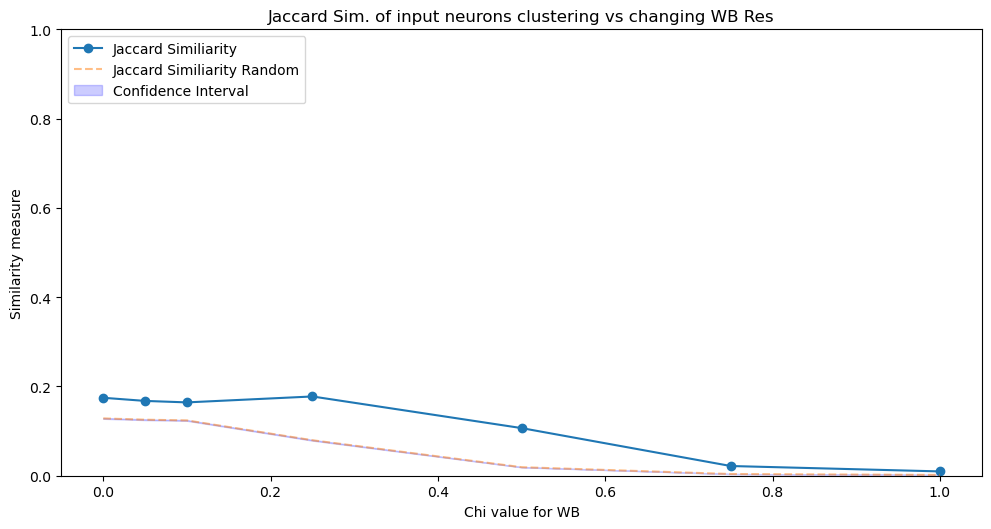

In [19]:
plt.figure(figsize=(10, 5))

# Calculate the confidence intervals
lower_bound = {res: jac_indices_random_mean[res] - jac_indices_random_std[res] for res in resolutions}
upper_bound = {res: jac_indices_random_mean[res] + jac_indices_random_std[res] for res in resolutions}

plt.plot([float(res) for res in resolutions], [jac_indices[res] for res in resolutions], marker='o', label = 'Jaccard Similiarity')
plt.plot([float(res) for res in resolutions], [jac_indices_random_mean[res] for res in resolutions], label = 'Jaccard Similiarity Random', linestyle = '--', alpha = 0.5)

# Plot the confidence intervals
plt.fill_between([float(res) for res in resolutions], [lower_bound[res] for res in resolutions], [upper_bound[res] for res in resolutions], color='b', alpha=0.2, label='Confidence Interval')


plt.legend(loc='upper left')
plt.tight_layout()
plt.ylim(0, 1)
plt.xlabel('Chi value for WB')
plt.ylabel('Similarity measure')
plt.title('Jaccard Sim. of input neurons clustering vs changing WB Res')
plt.show()

Out of curiosity, I wanted to see how the Jaccard similarity compares to the proportion of pairs in the same cluster. As might be expected, they look comparable which is reassuring. Jaccard similarity is a more intuitive measure for these data than the Rand similarity because the Jaccard similarity is more like a proportion and it somewhat evades the issue of there being more clusters for things to exist separately in at higher resolutions. This determines that Jaccard similarity is what we will present. 

In [20]:
import itertools

def cluster_similarity0(cluster_1, cluster_2, mode='both', node_filter=None):
    """
    Calculate the similarity between two clusterings using either the Jaccard index, Rand index, or both.

    Parameters:
    cluster_1 (dict): A dictionary representing the first clustering where keys are nodes and values are cluster labels.
    cluster_2 (dict): A dictionary representing the second clustering where keys are nodes and values are cluster labels.
    mode (str): The similarity measure to use ('jaccard', 'rand', or 'both'). Defaults to 'both'.
    node_filter (set, optional): A set of nodes to include in the comparison. If None, all nodes are included.

    Returns:
    float or tuple: The Jaccard index, Rand index, or both depending on the selected mode.
    
    Raises:
    AssertionError: If the mode is not one of 'jaccard', 'rand', or 'both', or if the clusterings do not have the same nodes.
    """
    # Ensure the mode is one of the valid options
    assert mode in ['jaccard', 'rand', 'both'], "Not a valid mode, please choose 'jaccard', 'rand' or 'both'"
    # Ensure both clusterings have the same set of nodes
    assert set(cluster_1.keys()) == set(cluster_2.keys())
    nodes = set(cluster_1.keys())
    
    # Apply node filter if provided
    if node_filter is not None:
        filter_set = set(node_filter)
        nodes = nodes.intersection(filter_set)
    
    # Initialize counters for pair counts
    f_0_0 = 0  # pair in different clusters in both clusterings
    f_0_1 = 0  # pair in different clusters in cluster_1 and same in cluster_2
    f_1_0 = 0  # pair in same cluster in cluster_1 and different in cluster_2
    f_1_1 = 0  # pair in same clusters in both clusterings

    # Count the number of pairs in each category
    for n1, n2 in itertools.combinations(nodes, 2):
        if cluster_1[n1] == cluster_1[n2] and cluster_2[n1] == cluster_2[n2]:
            f_1_1 += 1
        elif cluster_1[n1] == cluster_1[n2] and cluster_2[n1] != cluster_2[n2]:
            f_1_0 += 1
        elif cluster_1[n1] != cluster_1[n2] and cluster_2[n1] == cluster_2[n2]:
            f_0_1 += 1
        else:
            f_0_0 += 1
    #print(f_0_0 + f_1_0 + f_1_1 + f_0_1)
    # Calculate and return the similarity measure(s)
    if mode == 'jaccard':
        return f_1_1 / (f_1_1 + f_0_1 + f_1_0)
    if mode == 'rand':
        return (f_1_1 + f_0_0) / (f_1_1 + f_1_0 + f_0_1 + f_0_0)
    
    return f_0_0, f_0_1, f_1_0, f_1_1 #f_1_1 / (f_1_1 + f_0_1 + f_1_0), (f_1_1 + f_0_0) / (f_1_1 + f_1_0 + f_0_1 + f_0_0)


In [21]:
f00, f01, f10, f11 = cluster_similarity0(chi_run, chi_run_random)
f11/(f11 + f01 + f10)

0.08132483216831615

In [22]:
# proportion of pairs in the same cluster in both clusterings
prop_same_clust = f11/(f11 + f01 + f10 + f00)
prop_same_clust

0.022419562174009477

In [23]:
prop_same_clust = {}

for res in resolutions:
    f00, f01, f10, f11 = cluster_similarity0(hemibrain_clusters_filtered[res], chi_run)
    prop_same_clust[res] = f11/(f11 + f01 + f10 + f00)

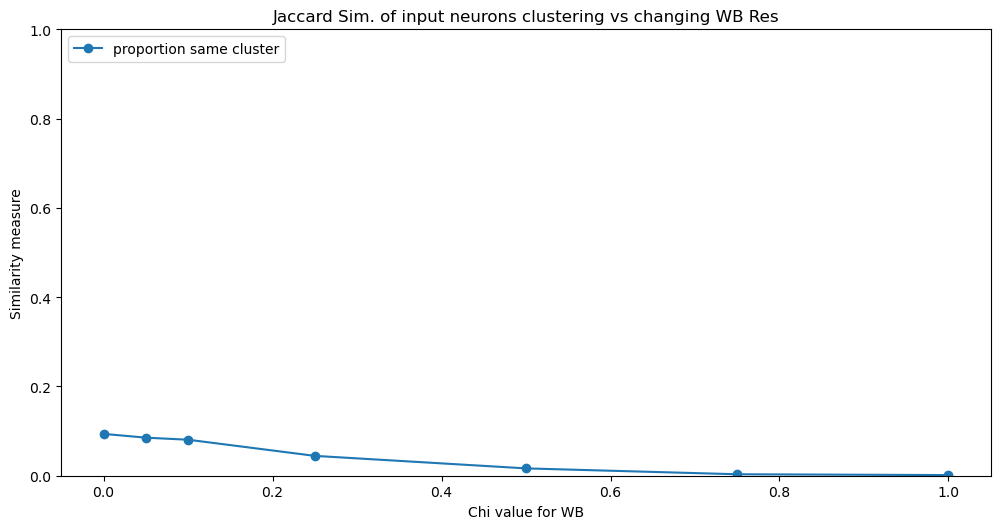

In [24]:
plt.figure(figsize=(10, 5))

plt.plot([float(res) for res in resolutions], [prop_same_clust[res] for res in resolutions], marker='o', label = 'proportion same cluster')

plt.legend(loc='upper left')
plt.tight_layout()
plt.ylim(0, 1)
plt.xlabel('Chi value for WB')
plt.ylabel('Similarity measure')
plt.title('Jaccard Sim. of input neurons clustering vs changing WB Res')
plt.show()

### Cluster-wise breakdown
We conduct the similarity analysis for different clusters. The Jaccard and Rand similarities become equivalent. 

In [25]:
cluster_nodes = {}
nodes = list(chi_run.keys())
for i in range(1, 8):
    cluster_nodes[i] = [node for node in nodes if chi_run[node] == i]

In [26]:
for i in range(1, 8):
    print(len(cluster_nodes[i]))

309
199
319
347
217
210
231


In [27]:
cluster_jac_similarities = {}
cluster_rand_similarities = {}

cluster_jac_similarities_random = {}
cluster_rand_similarities_random = {}

In [28]:
for i in range(1, 8):
    cluster_jac_similarities[i] = {}
    cluster_rand_similarities[i] = {}
    cluster_jac_similarities_random[i] = {}
    cluster_rand_similarities_random[i] = {}
    for res in resolutions:
        cluster_jac_similarities[i][res], cluster_rand_similarities[i][res] = cluster_similarity(chi_run, hemibrain_clusters_filtered[res], node_filter=cluster_nodes[i])

        values = list(chi_run.values())
        random.shuffle(values)
        chi_run_random = dict(zip(chi_run.keys(), values))

        cluster_jac_similarities_random[i][res], cluster_rand_similarities_random[i][res] = cluster_similarity(chi_run_random, hemibrain_clusters_filtered[res], node_filter=cluster_nodes[i])

In [29]:
colours = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink']

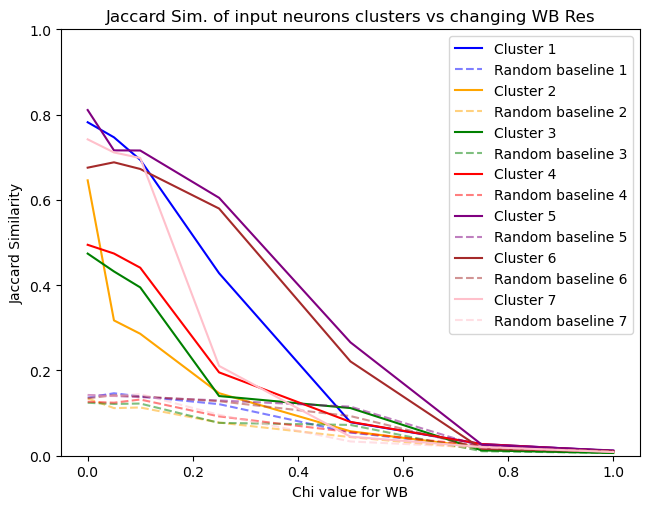

In [30]:
for i in range(1, 8):
    plt.plot([float(res) for res in resolutions],
             [cluster_jac_similarities[i][res] for res in resolutions],
             label = f'Cluster {i}',
             color = colours[i-1])
    plt.plot([float(res) for res in resolutions],
            [cluster_jac_similarities_random[i][res] for res in resolutions], 
            label = f'Random baseline {i}', linestyle = '--',
            color = colours[i-1], alpha = 0.5)
plt.legend()
plt.tight_layout()
plt.ylim(0, 1)
plt.xlabel('Chi value for WB')
plt.ylabel('Jaccard Similarity')
plt.title('Jaccard Sim. of input neurons clusters vs changing WB Res')
plt.show()